This notebook contains sensitivity analysis on height difference estimation assuming perspective projection. It visualises how each parameter impacts the height difference estimation, to help understand what parameters likely contribute to the uncertanty of final results.

### Load dependencies

In [17]:
import numpy as np
import matplotlib.pyplot as plt

### Set baseline/typical streetview imaging parameters
* some baseline parameters are referenced from RICS data
* need to update based on actual metadata provided
* set an error range for each parameter
* also set an acceptable error for estimated height difference

In [18]:
# Camera parameters
sensor_size = 0.0088          # Sensor width in meters (e.g., 8.8 mm)
image_resolution = 2448      # Image resolution in pixels
baseline_focal = 0.0085        # Focal length in meters (8.5 mm)

# Baseline parameters
baseline_pixel = 70          # Vertical pixel difference (y direction)
baseline_distance = 20.0      # Distance to object in meters
baseline_pitch = 10         # Baseline pitch angle in degrees

# Percent error range (e.g.-10% to +10%)
percent_error_range = np.linspace(-30, 30, 50)

# limit of acceptable error in estimated height difference (e.g. 20cm)
limit_height_error=0.2 

### Define function to estimate height difference given a set of parameters:
* distance measure on image (from segmentation)
* camera-object distance (from depth map/measure)
* focal length
* camera pitch angle

In [19]:
def height_difference_with_pitch(pixel_diff, distance, focal_length, sensor_size, image_resolution, pitch_angle):
    """
    Compute height difference using perspective projection with pitch angle correction.
    
    Parameters:
    - pixel_diff: Pixel difference (Delta y) in pixels
    - distance: Horizontal distance (meters)
    - focal_length: Focal length (meters)
    - sensor_size: Sensor size (meters)
    - image_resolution: Image resolution (pixels)
    - pitch_angle: Pitch angle (degrees, positive downward)
    
    Returns:
    - Height difference in meters
    """
    pixel_scale = sensor_size / image_resolution  # Derive pixel scale (meters/pixel)
    pitch_correction = np.cos(np.radians(pitch_angle))  # cos(theta) correction
    return (distance * pixel_diff * pixel_scale) / (focal_length * pitch_correction)

def compute_height_diff_for_ranges(baseline_pixel, baseline_distance, baseline_focal, baseline_pitch,
                                    sensor_size, image_resolution, percent_error_range):
    """
    Compute parameter ranges and corresponding height difference.
    """
    # Percent errors converted to multipliers
    error_multipliers = 1 + percent_error_range / 100.0

    # Ranges of parameter values
    pixel_range = baseline_pixel * error_multipliers
    distance_range = baseline_distance * error_multipliers
    focal_range = baseline_focal * error_multipliers
    pitch_range=baseline_pitch*error_multipliers

    # Baseline height difference
    baseline_height = height_difference_with_pitch(baseline_pixel, baseline_distance, 
                                        baseline_focal, sensor_size, image_resolution,baseline_pitch)

    # Height difference
    height_diff_pixel = [
        height_difference_with_pitch(p, baseline_distance, baseline_focal, sensor_size, image_resolution,baseline_pitch)
        for p in pixel_range
    ]
    height_diff_distance = [
        height_difference_with_pitch(baseline_pixel, d, baseline_focal, sensor_size, image_resolution,baseline_pitch)
        for d in distance_range
    ]
    height_diff_focal = [
        height_difference_with_pitch(baseline_pixel, baseline_distance, f, sensor_size, image_resolution,baseline_pitch)
        for f in focal_range
    ]
    height_diff_pitch = [
        height_difference_with_pitch(baseline_pixel, baseline_distance, baseline_focal, sensor_size, image_resolution,t)
        for t in pitch_range
    ]

    return (pixel_range, height_diff_pixel, 
            distance_range, height_diff_distance, 
            focal_range, height_diff_focal, 
            pitch_range, height_diff_pitch,
            baseline_height)


### Apply function to calculate height estimation ranges

In [20]:
# Compute parameter ranges and height estimations
(pixel_range, height_diff_pixel, 
 distance_range, height_diff_distance, 
 focal_range, height_diff_focal, 
 pitch_range, height_diff_pitch,
 baseline_height) = compute_height_diff_for_ranges(baseline_pixel, baseline_distance, baseline_focal, baseline_pitch, sensor_size, image_resolution, percent_error_range)

# Display Baseline
print(f"Baseline Height Difference: {baseline_height:.2f} m")

Baseline Height Difference: 0.60 m


### Plot the estimation dependent on each parameter
* Shading is applied when the acceptable limit of estimation exceeds, to help understand acceptable parameter errors:

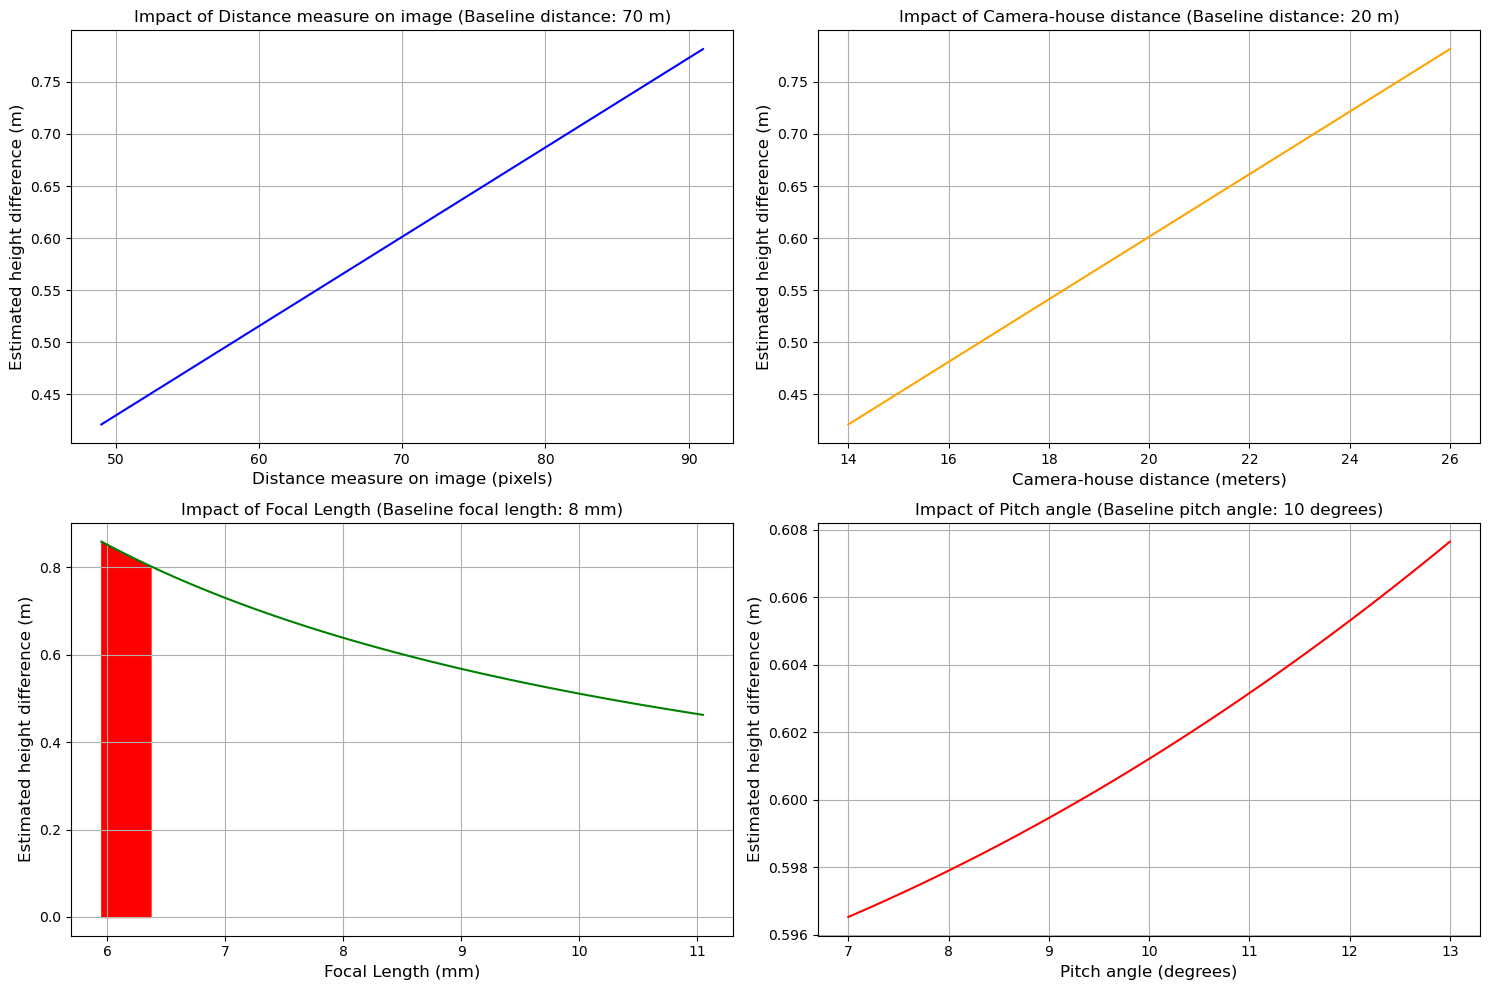

In [21]:
# Plotting the parameter ranges vs height difference
plt.figure(figsize=(15, 10))

# Pixel height Difference
plt.subplot(2, 2, 1)
plt.plot(pixel_range, height_diff_pixel, label="Height Difference (m)", color="blue")
plt.fill_between(pixel_range,height_diff_pixel,color='red',
                 where=((height_diff_pixel-baseline_height>limit_height_error)|(height_diff_pixel-baseline_height<-1.0*limit_height_error)))
plt.xlabel("Distance measure on image (pixels)",fontsize=12)
plt.ylabel("Estimated height difference (m)",fontsize=12)
plt.title(f"Impact of Distance measure on image (Baseline distance: {baseline_pixel:.0f} m)")
plt.grid(True)

# Distance
plt.subplot(2, 2, 2)
plt.plot(distance_range, height_diff_distance, label="Height Difference (m)", color="orange")
plt.fill_between(distance_range,height_diff_distance,color='red',
                 where=((height_diff_distance-baseline_height>limit_height_error)|(height_diff_distance-baseline_height<-1.0*limit_height_error)))
plt.xlabel("Camera-house distance (meters)",fontsize=12)
plt.ylabel("Estimated height difference (m)",fontsize=12)
plt.title(f"Impact of Camera-house distance (Baseline distance: {baseline_distance:.0f} m)")
plt.grid(True)

# Focal Length
plt.subplot(2, 2, 3)
plt.plot(focal_range*1000, height_diff_focal, label="Height Difference (m)", color="green")
plt.fill_between(focal_range*1000,height_diff_focal,color='red',
                 where=((height_diff_focal-baseline_height>limit_height_error)|(height_diff_focal-baseline_height<-1.0*limit_height_error)))
plt.xlabel("Focal Length (mm)",fontsize=12)
plt.ylabel("Estimated height difference (m)",fontsize=12)
plt.title(f"Impact of Focal Length (Baseline focal length: {baseline_focal*1000:.0f} mm)")
plt.grid(True)

# pitch angle
plt.subplot(2, 2, 4)
plt.plot(pitch_range, height_diff_pitch, label="Height Difference (m)", color="red")
plt.fill_between(pitch_range,height_diff_pitch,color='red',
                 where=((height_diff_pitch-baseline_height>limit_height_error)|(height_diff_pitch-baseline_height<-1.0*limit_height_error)))
plt.xlabel("Pitch angle (degrees)",fontsize=12)
plt.ylabel("Estimated height difference (m)",fontsize=12)
plt.title(f"Impact of Pitch angle (Baseline pitch angle: {baseline_pitch:.0f} degrees)")
plt.grid(True)

plt.tight_layout()
plt.show()


### Convert to percentage errors

In [25]:
# Compute parameter ranges and height errors
height_diff_error_pixel=[(h-baseline_height)/baseline_height*100 for h in height_diff_pixel]
height_diff_error_distance=[(d-baseline_height)/baseline_height*100 for d in height_diff_distance]
height_diff_error_focal=[(f-baseline_height)/baseline_height*100 for f in height_diff_focal]
height_diff_error_pitch=[(t-baseline_height)/baseline_height*100 for t in height_diff_pitch]

# calculated equivalent height difference estimation limits in percentage
upper_lmt_error_pct=100*((limit_height_error)/baseline_height)
lower_lmt_error_pct=upper_lmt_error_pct*(-1.0)

### Plot in percentage errors

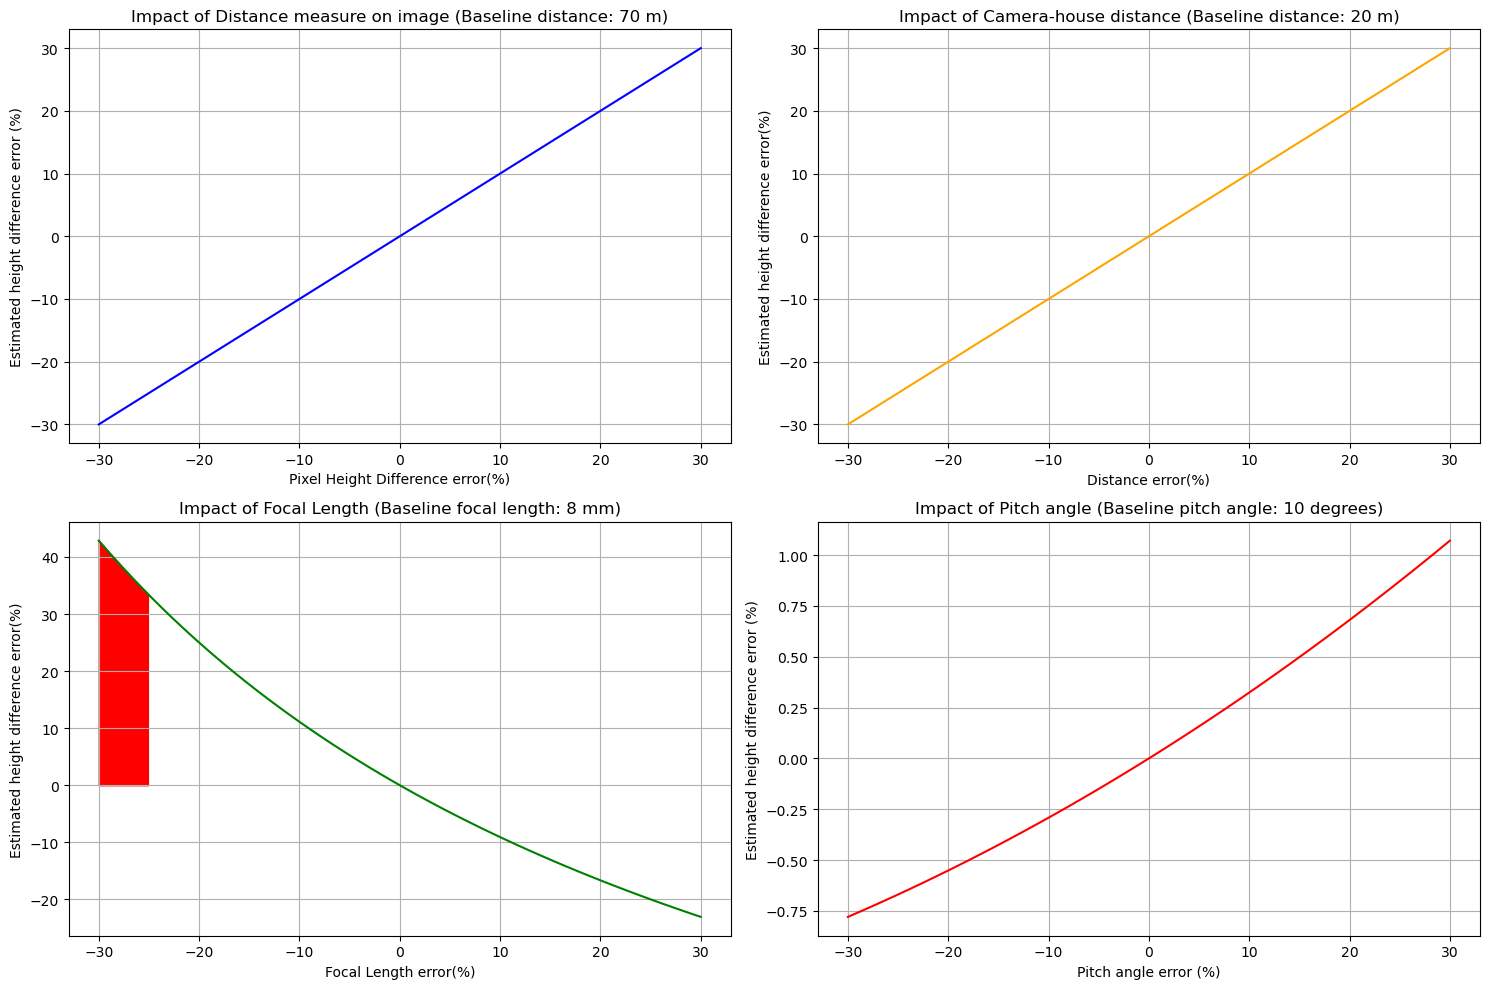

In [26]:

# Plotting the parameter ranges vs height difference errors
plt.figure(figsize=(15, 10))

# Pixel height Difference
plt.subplot(2, 2, 1)
plt.plot(percent_error_range, height_diff_error_pixel, label="Height Difference error(%)", color="blue")
plt.fill_between(percent_error_range,height_diff_error_pixel,color='red',
                 where=((height_diff_error_pixel<lower_lmt_error_pct)|(height_diff_error_pixel>upper_lmt_error_pct)))
plt.xlabel("Pixel Height Difference error(%)")
plt.ylabel("Estimated height difference error (%)")
plt.title(f"Impact of Distance measure on image (Baseline distance: {baseline_pixel:.0f} m)")
plt.grid(True)

# Distance
plt.subplot(2, 2, 2)
plt.plot(percent_error_range, height_diff_error_distance, label="Height Difference error(%)", color="orange")
plt.fill_between(percent_error_range,height_diff_error_distance,color='red',
                 where=((height_diff_error_distance<lower_lmt_error_pct)|(height_diff_error_distance>upper_lmt_error_pct)))
plt.xlabel("Distance error(%)")
plt.ylabel("Estimated height difference error(%)")
plt.title(f"Impact of Camera-house distance (Baseline distance: {baseline_distance:.0f} m)")
plt.grid(True)

# Focal Length
plt.subplot(2, 2, 3)
plt.plot(percent_error_range, height_diff_error_focal, label="Height Difference error(%)", color="green")
plt.fill_between(percent_error_range,height_diff_error_focal,color='red',
                 where=((height_diff_error_focal<lower_lmt_error_pct)|(height_diff_error_focal>upper_lmt_error_pct)))
plt.xlabel("Focal Length error(%)")
plt.ylabel("Estimated height difference error(%)")
plt.title(f"Impact of Focal Length (Baseline focal length: {baseline_focal*1000:.0f} mm)")
plt.grid(True)

# pitch angle
plt.subplot(2, 2, 4)
plt.plot(percent_error_range, height_diff_error_pitch, label="Height Difference error(%)", color="red")
plt.fill_between(percent_error_range,height_diff_error_pitch,color='red',
                 where=((height_diff_error_pitch<lower_lmt_error_pct)|(height_diff_error_pitch>upper_lmt_error_pct)))
plt.xlabel("Pitch angle error (%)")
plt.ylabel("Estimated height difference error (%)")
plt.title(f"Impact of Pitch angle (Baseline pitch angle: {baseline_pitch:.0f} degrees)")
plt.grid(True)

plt.tight_layout()
plt.show()
